In [ ]:
# Mount Google Drive, load API keys for Quandl, and set up environment variables for API access
from google.colab import drive
import json

drive.mount('/content/drive')

# Read API key from file
with open('/content/drive/My Drive/ML4T/api_keys.json', 'r') as f:
    api_keys = json.load(f)
    QUANDL_API_KEY = api_keys['QUANDL_API_KEY']

# Set the environment variable
%env QUANDL_API_KEY=$QUANDL_API_KEY

In [ ]:
# Download the TA-Lib source files from the official source using wget.
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz

# Extract the tar.gz file to access the source files.
!tar -xvzf ta-lib-0.4.0-src.tar.gz

# Change the directory to the extracted folder to run configuration and installation commands.
%cd ta-lib

# Configure the installation of TA-Lib for the system.
!./configure --prefix=/usr

# Compile the TA-Lib source files.
!make

# Install the compiled TA-Lib to the system directory.
!sudo make install

# Navigate back to the parent directory after installation is complete.
%cd ../

# Install the TA-Lib Python wrapper which allows the use of TA-Lib within Python scripts.
!pip install TA-Lib

!pip install zipline-reloaded
!pip install alphalens-reloaded
!pip install pyfolio-reloaded
!zipline ingest -b quandl
!pip install logbook
!pip install pyportfolioopt

# From `zipline` to `pyfolio`

[Pyfolio](http://quantopian.github.io/pyfolio/) facilitates the analysis of portfolio performance and risk in-sample and out-of-sample using many standard metrics. It produces tear sheets covering the analysis of returns, positions, and transactions, as well as event risk during periods of market stress using several built-in scenarios, and also includes Bayesian out-of-sample performance analysis.

Key features of pyfolio:
* Open-source backtester by Quantopian Inc.
* Powers Quantopian.com
* State-of-the-art portfolio and risk analytics
* Various models for transaction costs and slippage.
* Open source and free: Apache v2 license
* Can be used:
   - stand alone
   - with Zipline
   - on Quantopian

## Imports & Settings

In [3]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

import sys
import numpy as np
import pandas as pd
from pytz import UTC

from logbook import (NestedSetup, NullHandler, Logger, StreamHandler, StderrHandler,
                     INFO, WARNING, DEBUG, ERROR)

from zipline import run_algorithm
from zipline.api import (attach_pipeline,
                         date_rules,
                         time_rules,
                         get_datetime,
                         order_target_percent,
                         pipeline_output,
                         record,
                         schedule_function,
                         get_open_orders,
                         calendars,
                         set_commission,
                         set_slippage)
from zipline.finance import commission, slippage
from zipline.pipeline import Pipeline, CustomFactor
from zipline.pipeline.factors import Returns, AverageDollarVolume

from pyfolio.utils import extract_rets_pos_txn_from_zipline
from pyfolio.plotting import (plot_perf_stats,
                              show_perf_stats,
                              plot_rolling_beta,
                              plot_rolling_returns,
                              plot_rolling_sharpe,
                              plot_drawdown_periods,
                              plot_drawdown_underwater)

from pyfolio.timeseries import perf_stats, extract_interesting_date_ranges

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

In [5]:
from google.colab import drive
import shutil
import os

# Mount Google Drive if it's not already mounted
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# Define the source path (in Google Drive) and destination path (in Colab)
source_path = '/content/drive/MyDrive/ML4T/backtests.h5'
destination_path = '/content/backtests.h5'

# Check if the source file exists
if not os.path.exists(source_path):
    raise FileNotFoundError(f"The file {source_path} does not exist in your Google Drive.")

# Copy the file
shutil.copy2(source_path, destination_path)

# Verify that the file has been copied
if os.path.exists(destination_path):
    print(f"File successfully copied to {destination_path}")
    print(f"File size: {os.path.getsize(destination_path) / (1024 * 1024):.2f} MB")
else:
    print("File copy failed")

File successfully copied to /content/backtests.h5
File size: 33.82 MB


## Converting data from zipline to pyfolio

We'll start by loading our backtest results and converting them into a format that pyfolio can use.

In [7]:
with pd.HDFStore('backtests.h5') as store:
    backtest = store['backtest/equal_weight']
backtest.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1008 entries, 2013-01-02 00:00:00+00:00 to 2016-12-30 00:00:00+00:00
Data columns (total 39 columns):
 #   Column                   Non-Null Count  Dtype              
---  ------                   --------------  -----              
 0   period_open              1008 non-null   datetime64[ns, UTC]
 1   period_close             1008 non-null   datetime64[ns, UTC]
 2   returns                  1008 non-null   float64            
 3   ending_exposure          1008 non-null   float64            
 4   starting_value           1008 non-null   float64            
 5   ending_value             1008 non-null   float64            
 6   starting_cash            1008 non-null   float64            
 7   ending_cash              1008 non-null   float64            
 8   portfolio_value          1008 non-null   float64            
 9   longs_count              1008 non-null   int64              
 10  shorts_count             1008 non-null   int64  

`pyfolio` relies on portfolio returns and position data, and can also take into account the transaction costs and slippage losses of trading activity. The metrics are computed using the empyrical library that can also be used on a standalone basis. The performance DataFrame produced by the zipline backtesting engine can be translated into the requisite pyfolio input.

In [8]:
returns, positions, transactions = extract_rets_pos_txn_from_zipline(backtest)

In [9]:
pd.concat((returns.head(),(returns.tail())))

,returns
2013-01-02 00:00:00+00:00,0.000000
2013-01-03 00:00:00+00:00,0.000000
2013-01-04 00:00:00+00:00,0.000000
2013-01-07 00:00:00+00:00,0.000000
2013-01-08 00:00:00+00:00,-0.000005
2016-12-23 00:00:00+00:00,-0.000233
2016-12-27 00:00:00+00:00,0.000160
2016-12-28 00:00:00+00:00,-0.000847
2016-12-29 00:00:00+00:00,0.000735
2016-12-30 00:00:00+00:00,-0.000606


In [10]:
returns.shape

(1008,)

In [11]:
positions.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1004 entries, 2013-01-08 00:00:00+00:00 to 2016-12-30 00:00:00+00:00
Columns: 750 entries, Equity(0 [A]) to cash
dtypes: float64(750)
memory usage: 5.8 MB


In [12]:
positions.columns = [c for c in positions.columns[:-1]] + ['cash']
positions.index = positions.index.normalize()
positions.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1004 entries, 2013-01-08 00:00:00+00:00 to 2016-12-30 00:00:00+00:00
Columns: 750 entries, Equity(0 [A]) to cash
dtypes: float64(750)
memory usage: 5.8 MB


In [13]:
transactions.symbol = transactions.symbol.apply(lambda x: x.symbol)

In [14]:
pd.concat((transactions.head(),(transactions.tail())))

,sid,symbol,price,order_id,amount,commission,dt,txn_dollars
2013-01-08 21:00:00+00:00,Equity(85 [AGN]),AGN,86.680005,bc144a3c209243989e0e72568f334da8,2334,None,2013-01-08 21:00:00+00:00,-202311.131306
2013-01-08 21:00:00+00:00,Equity(213 [ARIA]),ARIA,19.651001,1784ac5a2a7d44a28a6d344e916ba6b9,7590,None,2013-01-08 21:00:00+00:00,-149151.099321
2013-01-08 21:00:00+00:00,Equity(367 [BIIB]),BIIB,144.390001,baa93d795a0d4f3f8f85c9e282153229,1365,None,2013-01-08 21:00:00+00:00,-197092.351185
2013-01-08 21:00:00+00:00,Equity(811 [DFS]),DFS,40.090001,143c69da6782429aa4428ae7d849e6b7,5073,None,2013-01-08 21:00:00+00:00,-203376.572741
2013-01-08 21:00:00+00:00,Equity(1059 [FDO]),FDO,57.320002,45eb02083d12440386883c12a9b9cfe7,3496,None,2013-01-08 21:00:00+00:00,-200390.728571
2016-12-29 21:00:00+00:00,Equity(66 [AEO]),AEO,15.270000,abf7bf58c4cc4b46898a9f1e78a3d7ca,3461,None,2016-12-29 21:00:00+00:00,-52849.470534
2016-12-29 21:00:00+00:00,Equity(833 [DKS]),DKS,52.380000,cee0c10cf5f8467c91845ab42b195f55,1063,None,2016-12-29 21:00:00+00:00,-55679.940343
2016-12-29 21:00:00+00:00,Equity(1757 [MAT]),MAT,27.630000,9abdbf1086ca4c71a76f0682cf86ec90,1183,None,2016-12-29 21:00:00+00:00,-32686.290035
2016-12-30 21:00:00+00:00,Equity(2181 [PDCO]),PDCO,41.030000,87a90c2a520444d4828c3bd13740804d,-119,None,2016-12-30 21:00:00+00:00,4882.569999
2016-12-30 21:00:00+00:00,Equity(2953 [URBN]),URBN,28.480000,37a48c20bb2a41c19d9bed376b940bc9,-1006,None,2016-12-30 21:00:00+00:00,28650.879685


In [15]:
from pathlib import Path
HDF_PATH = Path('drive', 'MyDrive', 'ML4T', 'assets.h5')

### Sector Map

In [16]:
assets = positions.columns[:-1]
with pd.HDFStore(HDF_PATH) as store:
    df = store.get('us_equities/stocks')['sector'].dropna()
    df = df[~df.index.duplicated()]
sector_map = df.reindex(assets).fillna('Unknown').to_dict()

### Benchmark

In [17]:
with pd.HDFStore(HDF_PATH) as store:
    benchmark_rets = store['sp500/stooq'].close.pct_change()
benchmark_rets.name = 'S&P500'
benchmark_rets = benchmark_rets.tz_localize('UTC').filter(returns.index)
benchmark_rets.tail()

,S&P500
2016-12-23 00:00:00+00:00,0.001252
2016-12-27 00:00:00+00:00,0.002248
2016-12-28 00:00:00+00:00,-0.008357
2016-12-29 00:00:00+00:00,-0.000293
2016-12-30 00:00:00+00:00,-0.004637


In [18]:
benchmark_rets.head()

,S&P500
2013-01-02 00:00:00+00:00,0.025403
2013-01-03 00:00:00+00:00,-0.002086
2013-01-04 00:00:00+00:00,0.004865
2013-01-07 00:00:00+00:00,-0.003123
2013-01-08 00:00:00+00:00,-0.003242


In [19]:
benchmark_rets.shape

(1008,)

In [20]:
# Calculate performance statistics
perf_stats_result = perf_stats(returns=returns, factor_returns=benchmark_rets)

# Display the performance statistics
print(perf_stats_result)

Annual return          0.019619
Cumulative returns     0.080817
Annual volatility      0.047487
Sharpe ratio           0.432879
Calmar ratio           0.336024
Stability              0.555919
Max drawdown          -0.058387
Omega ratio            1.085094
Sortino ratio          0.630497
Skew                   0.223701
Kurtosis               6.125539
Tail ratio             0.988875
Daily value at risk   -0.005901
Alpha                  0.005922
Beta                   0.121033
dtype: float64


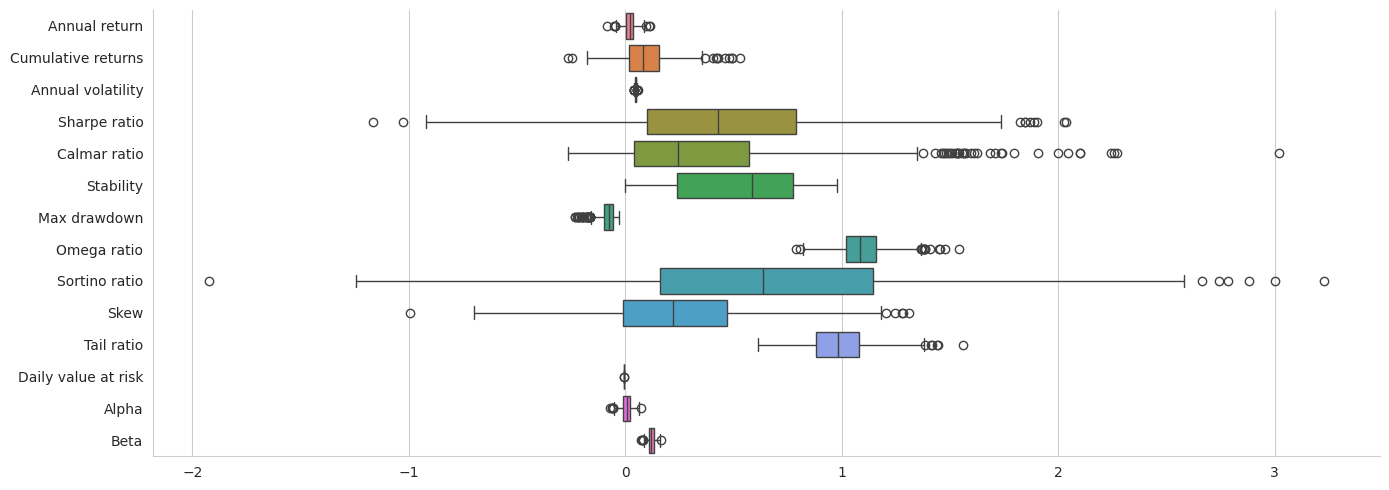

In [21]:
# Create a new figure and axis for plotting
fig, ax = plt.subplots(figsize=(14, 5))

# Plot the performance statistics
plot_perf_stats(returns=returns,
                factor_returns=benchmark_rets,
                ax=ax)

# Remove the top and right spines of the plot
sns.despine()

# Adjust the layout to prevent overlapping
fig.tight_layout()

Performance Statistics:
Annual return          0.019619
Cumulative returns     0.080817
Annual volatility      0.047487
Sharpe ratio           0.432879
Calmar ratio           0.336024
Stability              0.555919
Max drawdown          -0.058387
Omega ratio            1.085094
Sortino ratio          0.630497
Skew                   0.223701
Kurtosis               6.125539
Tail ratio             0.988875
Daily value at risk   -0.005901
Alpha                  0.005922
Beta                   0.121033
dtype: float64


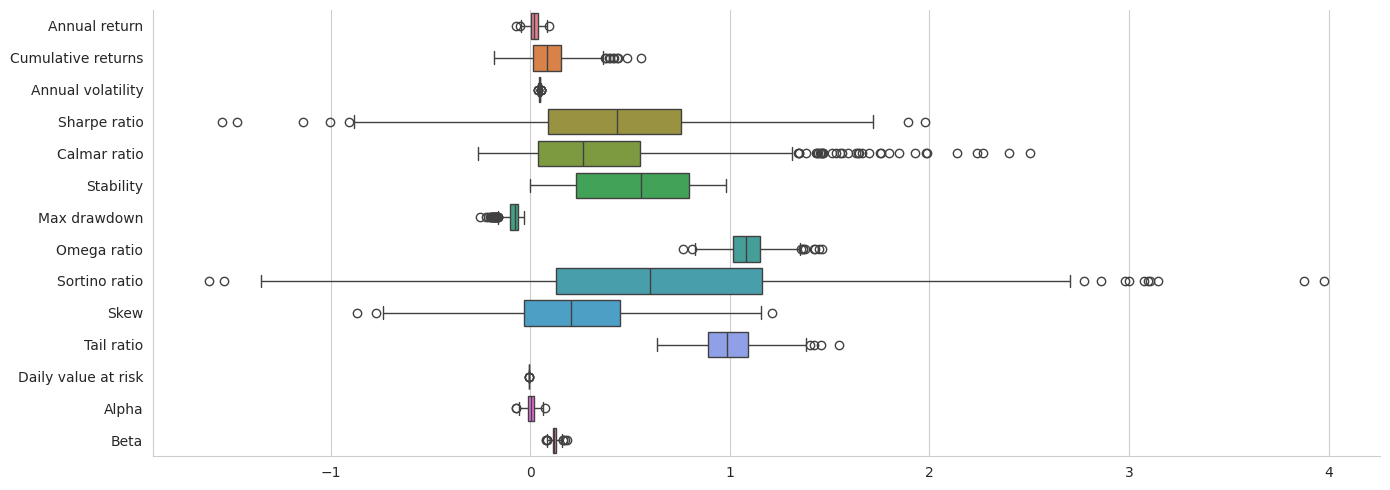


Returns shape: (1008,)
Benchmark returns shape: (1008,)

Returns index range: 2013-01-02 00:00:00+00:00 to 2016-12-30 00:00:00+00:00
Benchmark returns index range: 2013-01-02 00:00:00+00:00 to 2016-12-30 00:00:00+00:00

First few rows of returns:
2013-01-02 00:00:00+00:00    0.000000
2013-01-03 00:00:00+00:00    0.000000
2013-01-04 00:00:00+00:00    0.000000
2013-01-07 00:00:00+00:00    0.000000
2013-01-08 00:00:00+00:00   -0.000005
Name: returns, dtype: float64

First few rows of benchmark returns:
2013-01-02 00:00:00+00:00    0.025403
2013-01-03 00:00:00+00:00   -0.002086
2013-01-04 00:00:00+00:00    0.004865
2013-01-07 00:00:00+00:00   -0.003123
2013-01-08 00:00:00+00:00   -0.003242
Name: S&P500, dtype: float64


In [22]:
# Ensure that benchmark returns and strategy returns have the same index
common_index = returns.index.intersection(benchmark_rets.index)
returns = returns.loc[common_index]
benchmark_rets = benchmark_rets.loc[common_index]

# Calculate performance statistics
try:
    perf_stats_result = perf_stats(returns=returns, factor_returns=benchmark_rets)
    print("Performance Statistics:")
    print(perf_stats_result)
except Exception as e:
    print(f"Error calculating performance statistics: {e}")

# Create a new figure and axis for plotting
fig, ax = plt.subplots(figsize=(14, 5))

# Plot the performance statistics
try:
    plot_perf_stats(returns=returns,
                    factor_returns=benchmark_rets,
                    ax=ax)

    # Remove the top and right spines of the plot
    sns.despine()

    # Adjust the layout to prevent overlapping
    fig.tight_layout()

    plt.show()
except Exception as e:
    print(f"Error plotting performance statistics: {e}")

# Print some diagnostic information
print("\nReturns shape:", returns.shape)
print("Benchmark returns shape:", benchmark_rets.shape)
print("\nReturns index range:", returns.index.min(), "to", returns.index.max())
print("Benchmark returns index range:", benchmark_rets.index.min(), "to", benchmark_rets.index.max())

# Display the first few rows of each series to check alignment
print("\nFirst few rows of returns:")
print(returns.head())
print("\nFirst few rows of benchmark returns:")
print(benchmark_rets.head())

## Returns Analysis

Testing a trading strategy involves backtesting against historical data to fine-tune alpha factor parameters, as well as forward-testing against new market data to validate that the strategy performs well out of sample or if the parameters are too closely tailored to specific historical circumstances.

Pyfolio allows for the designation of an out-of-sample period to simulate walk-forward testing. There are numerous aspects to take into account when testing a strategy to obtain statistically reliable results, which we will address here.

In [23]:
# Set the out-of-sample date
oos_date = '2016-01-01'

# Display detailed performance statistics
show_perf_stats(returns=returns,
                factor_returns=benchmark_rets,
                positions=positions,
                transactions=transactions,
                live_start_date=oos_date)



### Rolling Returns OOS

The `plot_rolling_returns` function displays cumulative in and out-of-sample returns against a user-defined benchmark (we are using the S&P 500):

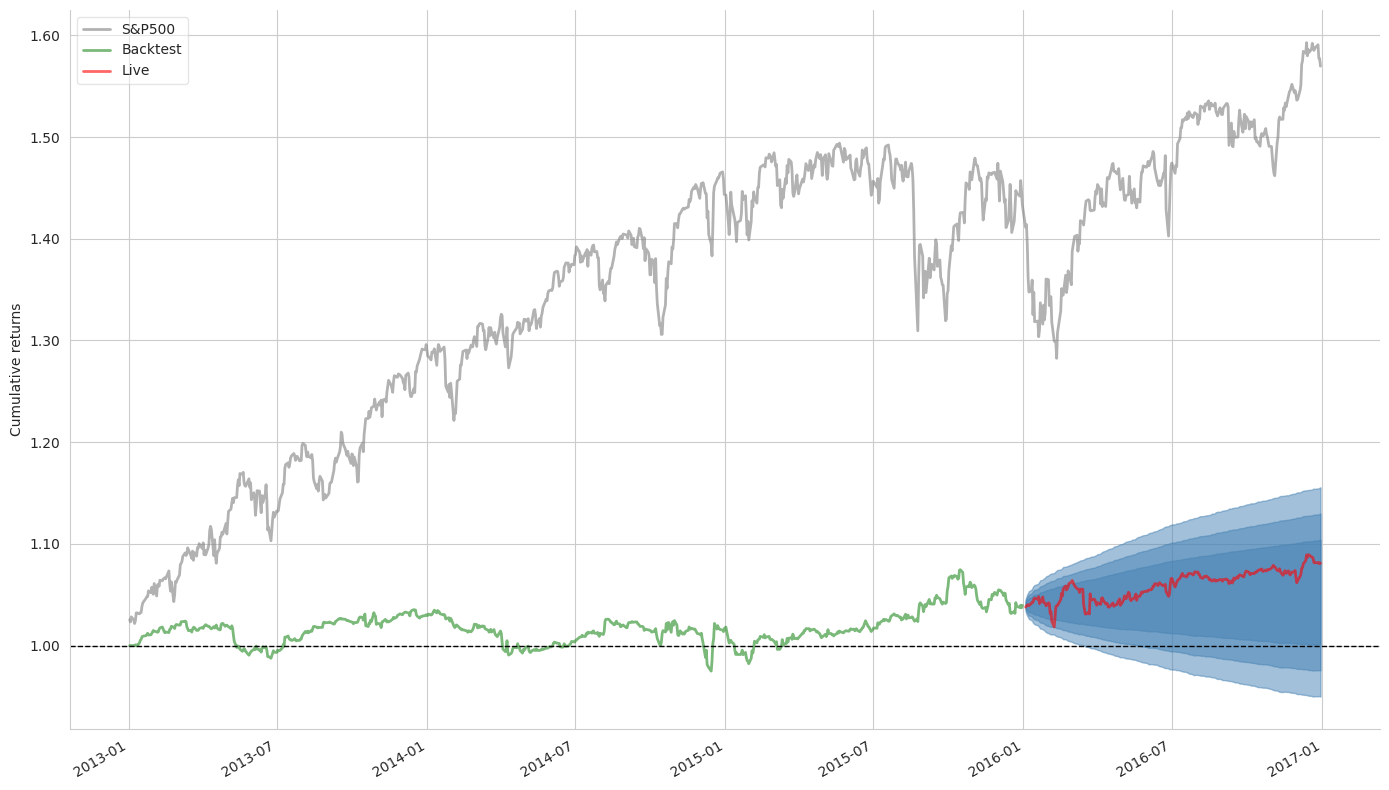

In [24]:
# Plot rolling returns
plot_rolling_returns(returns=returns,
                     factor_returns=benchmark_rets,
                     live_start_date=oos_date,
                     cone_std=(1.0, 1.5, 2.0))

# Set the figure size
plt.gcf().set_size_inches(14, 8)

# Remove the top and right spines of the plot
sns.despine()

# Adjust the layout to prevent overlapping
plt.tight_layout()

The plot includes a cone that shows expanding confidence intervals to indicate when out-of-sample returns appear unlikely given random-walk assumptions. Here, our strategy did not perform well against the benchmark during the simulated 2017 out-of-sample period

## Summary Performance Statistics

pyfolio offers several analytic functions and plots. The perf_stats summary displays the annual and cumulative returns, volatility, skew, and kurtosis of returns and the SR. The following additional metrics (which can also be calculated individually) are most important:
- Max drawdown: Highest percentage loss from the previous peak
- Calmar ratio: Annual portfolio return relative to maximal drawdown
- Omega ratio: The probability-weighted ratio of gains versus losses for a return target, zero per default
- Sortino ratio: Excess return relative to downside standard deviation
- Tail ratio: Size of the right tail (gains, the absolute value of the 95th percentile) relative to the size of the left tail (losses, abs. value of the 5th percentile)
- Daily value at risk (VaR): Loss corresponding to a return two standard deviations below the daily mean
- Alpha: Portfolio return unexplained by the benchmark return
- Beta: Exposure to the benchmark

### Rolling Sharpe

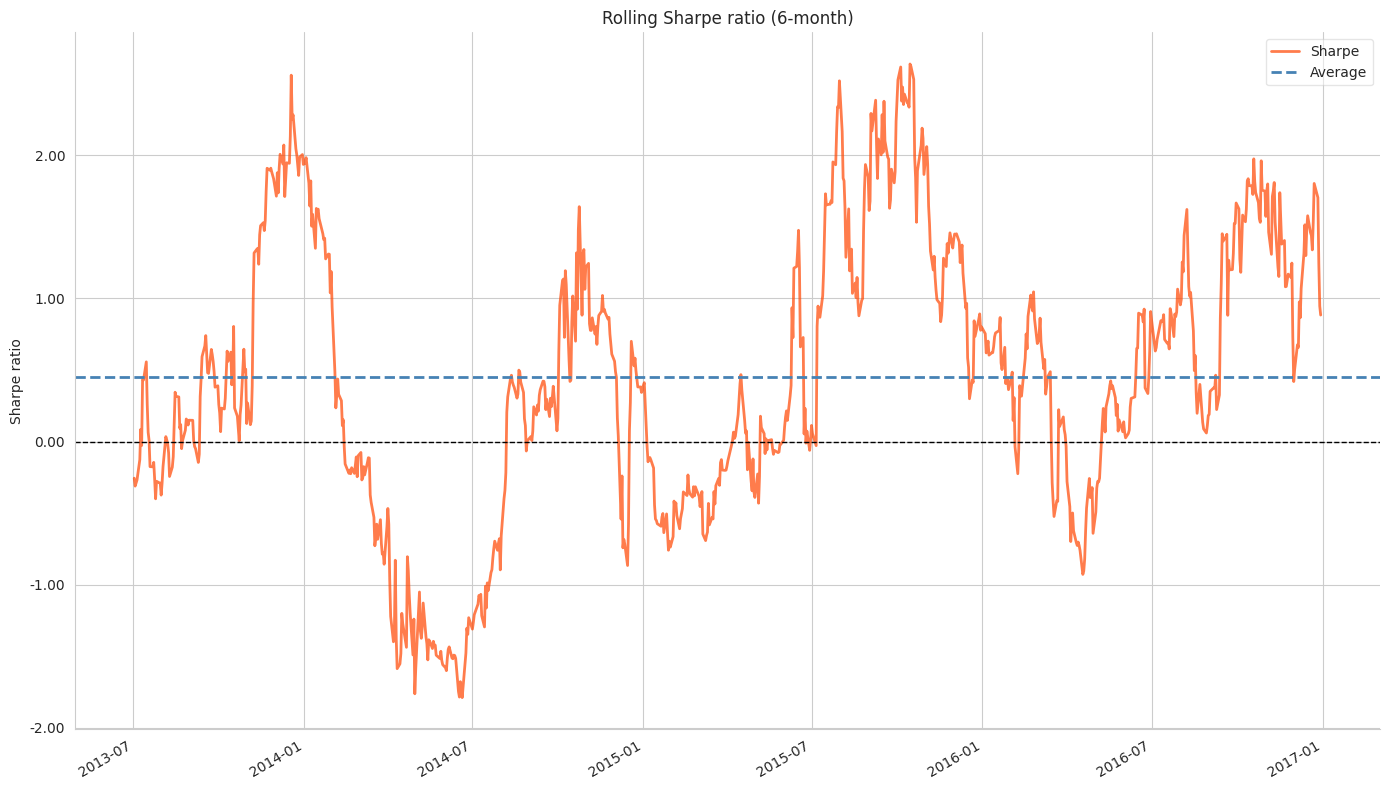

In [25]:
# Plot the rolling Sharpe ratio
plot_rolling_sharpe(returns=returns)

# Set the figure size
plt.gcf().set_size_inches(14, 8)

# Remove the top and right spines of the plot
sns.despine()

# Adjust the layout to prevent overlapping
plt.tight_layout()



### Rolling Beta

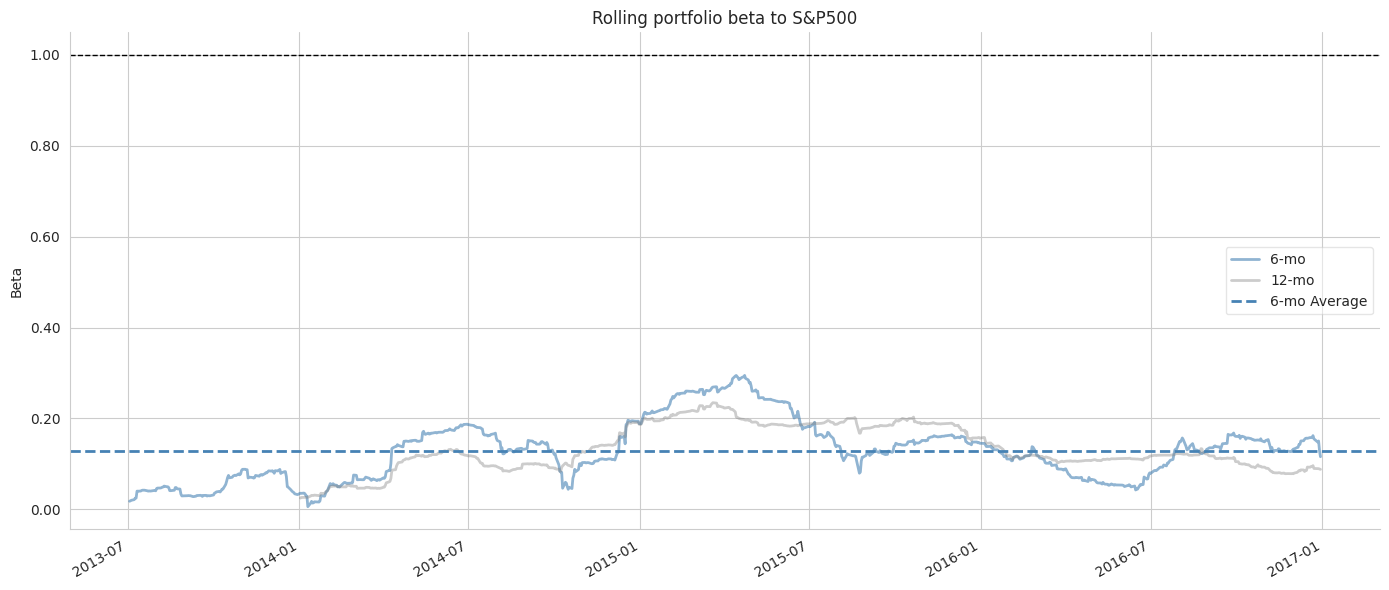

In [26]:
# Plot the rolling beta
plot_rolling_beta(returns=returns, factor_returns=benchmark_rets)

# Set the figure size
plt.gcf().set_size_inches(14, 6)

# Remove the top and right spines of the plot
sns.despine()

# Adjust the layout to prevent overlapping
plt.tight_layout()

## Drawdown Periods

The plot_drawdown_periods(returns) function plots the principal drawdown periods for the portfolio, and several other plotting functions show the rolling SR and rolling factor exposures to the market beta or the Fama French size, growth, and momentum factors:

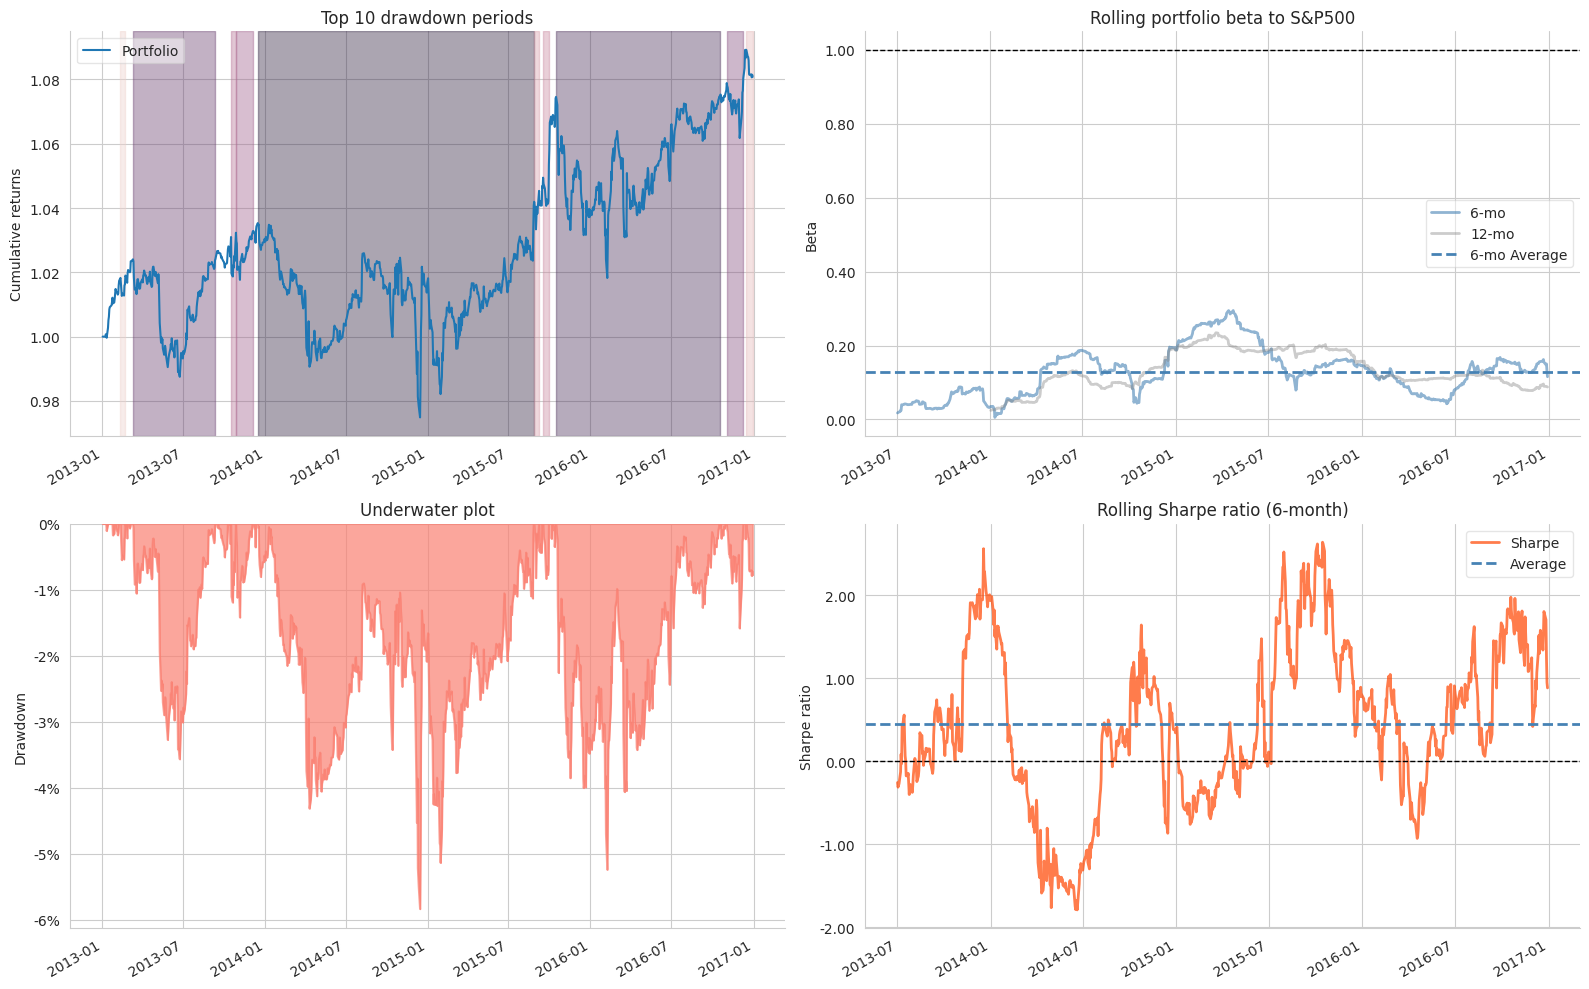

In [27]:
# Create a 2x2 grid of subplots
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))
axes = ax.flatten()

# Plot drawdown periods
plot_drawdown_periods(returns=returns, ax=axes[0])

# Plot rolling beta
plot_rolling_beta(returns=returns, factor_returns=benchmark_rets, ax=axes[1])

# Plot underwater plot (continuous drawdown)
plot_drawdown_underwater(returns=returns, ax=axes[2])

# Plot rolling Sharpe ratio
plot_rolling_sharpe(returns=returns)

# Remove the top and right spines of all subplots
sns.despine()

# Adjust the layout to prevent overlapping
plt.tight_layout()

## Modeling Event Risk

Pyfolio also includes timelines for various events that you can use to compare the performance of a portfolio to a benchmark during this period, for example, during the fall 2015 selloff following the Brexit vote.

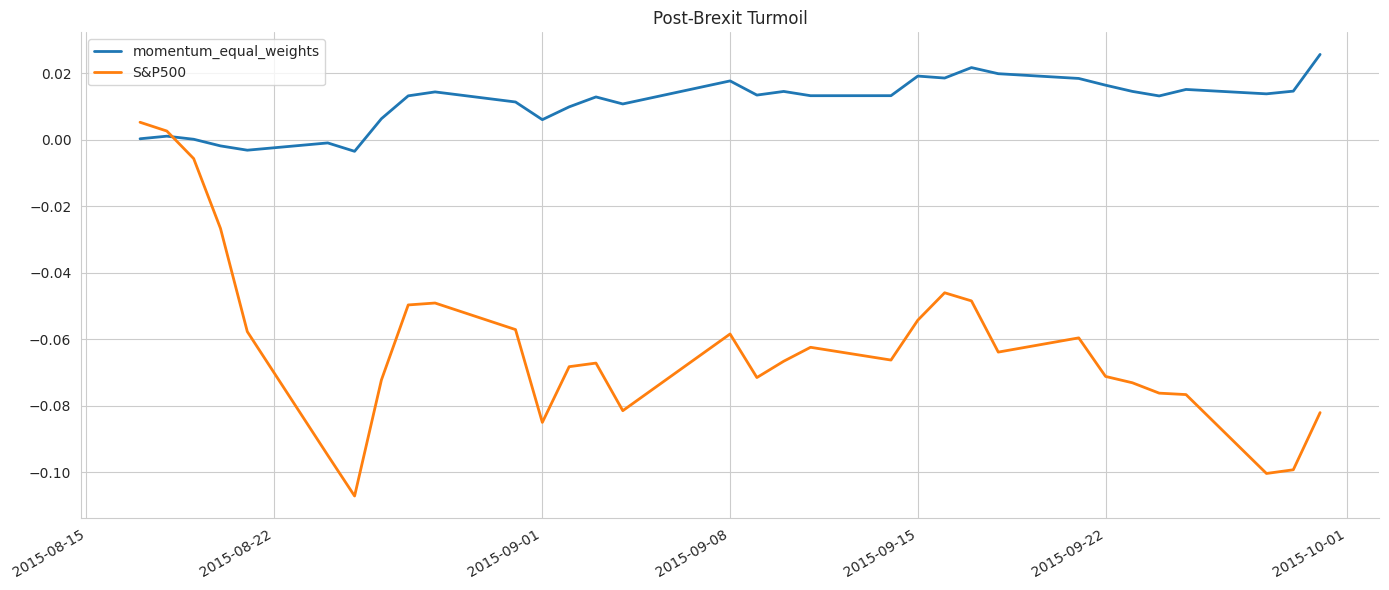

In [28]:
# Extract interesting date ranges from the returns
interesting_times = extract_interesting_date_ranges(returns=returns)

# Select the 'Fall2015' period and plot it
(interesting_times['Fall2015']
 .to_frame('momentum_equal_weights')  # Convert Series to DataFrame
 .join(benchmark_rets)  # Join with benchmark returns
 .add(1).cumprod().sub(1)  # Calculate cumulative returns
 .plot(lw=2, figsize=(14, 6), title='Post-Brexit Turmoil'))

# Remove the top and right spines of the plot
sns.despine()

# Adjust the layout to prevent overlapping
plt.tight_layout()